## Analyzing Consumer Sentiment of Future Trends in the Economy  
### Jack Boydell, David Richardson, Madeline Van Slyke, Alex Bamberger
### Willamette University, CS 475, Professor Cheng

Importing necessary packages, heavy use of sklearn.

In [378]:
import pandas as pd
import numpy as np 
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error as MSE, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans, DBSCAN 

Setting the style for visulizations and plots.

In [379]:
plt.style.use('seaborn-whitegrid') 

#### Our analysis involved two avenues of classification tasks: 1) change in unemployment rates analysis, 2) change in interest rates analysis.

### Unemployment Rates Analysis

In [380]:
unemp_rates = pd.read_csv('/Users/jackboydell/Desktop/CS 475/Consumer Sentiment Project/unemployment_rates_final.csv')
back_up_df = unemp_rates.copy()
unemp_rates.head()

,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,month.1,unemployment_rate,one_month_net_change,twelve_month_net_change,one_month_percent_change,twelve_month_percent_change
0,1978-01-31,1978,1,20,48,30,2,90,1979,1,5.9,-0.1,-0.5,-1.7,-7.8
1,1978-02-28,1978,2,30,41,24,5,106,1979,2,5.9,0.0,-0.4,0.0,-6.3
2,1978-03-31,1978,3,14,52,31,3,83,1979,3,5.8,-0.1,-0.5,-1.7,-7.9
3,1978-04-30,1978,4,17,56,25,2,92,1979,4,5.8,0.0,-0.3,0.0,-4.9
4,1978-05-31,1978,5,23,45,26,6,97,1979,5,5.6,-0.2,-0.4,-3.4,-6.7


In [381]:
unemp_rates.info()
unemp_rates['date'] = pd.to_datetime(unemp_rates['date']) # changing full date column to Datetime object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 15 columns):
date                           518 non-null object
year                           518 non-null int64
month                          518 non-null int64
go_up                          518 non-null int64
stay_same                      518 non-null int64
go_down                        518 non-null int64
dk_na                          518 non-null int64
relative                       518 non-null int64
year.1                         518 non-null int64
month.1                        518 non-null int64
unemployment_rate              518 non-null float64
one_month_net_change           518 non-null float64
twelve_month_net_change        518 non-null float64
one_month_percent_change       518 non-null float64
twelve_month_percent_change    518 non-null float64
dtypes: float64(5), int64(9), object(1)
memory usage: 60.8+ KB


The function below takes a given dataframe and specified numerical column and converts into a binary category. This will be used for classifying the change in unemployment as positive or negative.

In [382]:
# calculating positive(0) or negative(1) one month net change and applying as a categorical variable 
# this can be repeated for other columns that we want to look at as a categoery
def pos_neg_category(df, old_col_name, new_col_name):
    '''
    df: (Pandas DataFrame)
    old_col_name: (name of numerical column to convert into a binary c)
    new_col_name: (name to be assigned to new column created)
    '''
    lst = [] 
    for value in df[old_col_name]:
        if value < 0:
            lst.append(1)
        else:
            lst.append(0)
            
    df = pd.concat([df, pd.Series(lst, name=new_col_name)], axis=1)
    df[new_col_name] = df[new_col_name].astype('category')
    
    return df

In [383]:
# utilizing the function above on unemp_rates dataframe
unemp_rates = pos_neg_category(unemp_rates, 'one_month_net_change', 'OMNC_cat')
unemp_rates.head()

,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,month.1,unemployment_rate,one_month_net_change,twelve_month_net_change,one_month_percent_change,twelve_month_percent_change,OMNC_cat
0,1978-01-31,1978,1,20,48,30,2,90,1979,1,5.9,-0.1,-0.5,-1.7,-7.8,1
1,1978-02-28,1978,2,30,41,24,5,106,1979,2,5.9,0.0,-0.4,0.0,-6.3,0
2,1978-03-31,1978,3,14,52,31,3,83,1979,3,5.8,-0.1,-0.5,-1.7,-7.9,1
3,1978-04-30,1978,4,17,56,25,2,92,1979,4,5.8,0.0,-0.3,0.0,-4.9,0
4,1978-05-31,1978,5,23,45,26,6,97,1979,5,5.6,-0.2,-0.4,-3.4,-6.7,1


In [384]:
# minimum and maximum unemployment rates in our data 
min_ = unemp_rates['unemployment_rate'].min()
max_ = unemp_rates['unemployment_rate'].max()
print(min_, max_)

3.5 14.7


The following code prepares and executes a time-series visualization for exploratory data analysis (EDA).

In [385]:
ordered_dec = unemp_rates.sort_values('go_down', ascending=False)
viz_date = '2009-02-28'
viz_row = unemp_rates.loc[unemp_rates['date'] == '2009-02-28']

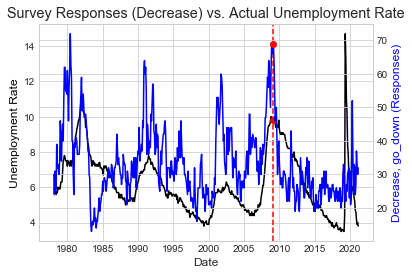

In [386]:
#time series visualization 
fig, ax1 = plt.subplots()
plt.title('Survey Responses (Decrease) vs. Actual Unemployment Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Unemployment Rate', c = 'black')
ax1.plot('date', 'unemployment_rate', data = unemp_rates, c='black')
ax1.plot(viz_row['date'], viz_row['unemployment_rate'], marker = 'o', c='red')
ax1.axvline(x=viz_row['date'], c='red', ls='--')


ax2 = ax1.twinx()
ax2.set_ylabel('Decrease, go_down (Responses)', c='blue')
ax2.plot('date', 'go_down', data=unemp_rates, c='blue')
ax2.plot(viz_row['date'], viz_row['go_down'], marker = 'o', c='red')

plt.show()

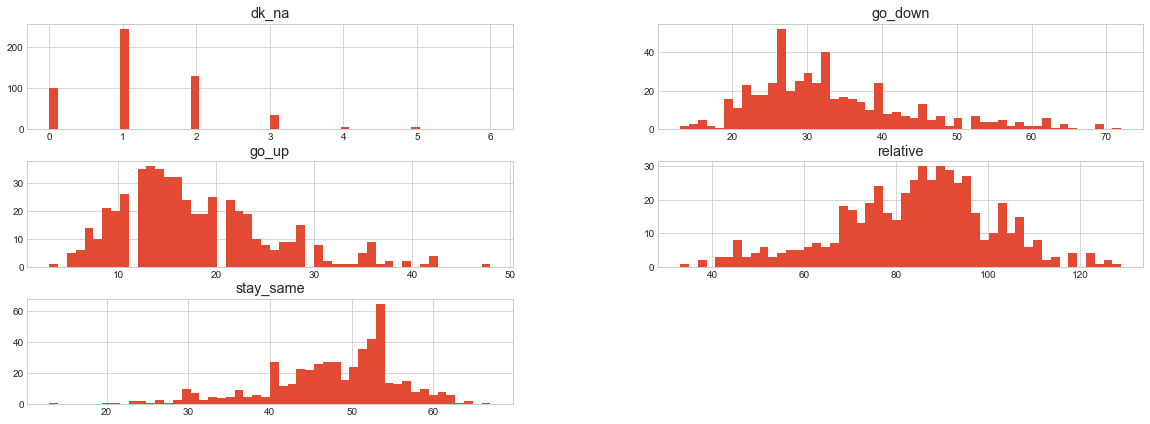

In [387]:
# distributions of survey columns
dist_columns = ['go_up', 'stay_same', 'go_down', 'dk_na', 'relative']
unemp_rates[dist_columns].hist(bins = 50, figsize=(20,7))
plt.show()

### One Month Net Change Category (OMNC cat) as target variable 
consider going through mutliclass classification: positive, 0, negative

In [388]:
# preparing X, y for model fitting
X = unemp_rates.loc[:, ['go_up', 'stay_same', 'go_down', 'dk_na', 'relative']]
print(f'Column Variances:\n{X.var()}') # looking at variances, do we need to impose a standard scale?

y = unemp_rates['OMNC_cat'].to_numpy()
X = X.to_numpy()

Column Variances:
go_up         58.028144
stay_same     68.434378
go_down      119.609777
dk_na          0.951584
relative     285.565521
dtype: float64


In [389]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 21)

In [390]:
# testing out basic LogisitcRegression as a classifier
logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_pred, y_test)}')
y_pred_proba = logreg.predict_proba(X_test)[:,1]
print(f'ROC-AUC score: {roc_auc_score(y_test, y_pred_proba)}') # think about plotting ROC-AUC scores for each C, or other hyperparameter

Accuracy score: 0.6153846153846154
ROC-AUC score: 0.5327868852459017


In [391]:
# GridSearchCV for basic LogisitcRegression 
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l1', 'l2']}

grid_search = GridSearchCV(logreg, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
grid_search.best_score_

{'C': 0.001, 'penalty': 'l1'}


0.5893719806763285

In [392]:
# Linear SVM Classifier
scaler = StandardScaler()
lin_svm_clf = SVC(kernel='linear', C=100)

scaled_svc = Pipeline([('scaler', scaler), ('linear_svc', lin_svm_clf)])
scaled_svc.fit(X_train, y_train)
y_pred = scaled_svc.predict(X_test)
accuracy_score(y_pred, y_test)

0.5865384615384616

In [393]:
# Decision Trees Classifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth = 4, random_state=21)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.5673076923076923

In [394]:
#cross validation for decision tree classifier
cross_val_score(dt_clf, X_train, y_train, cv=5)

array([0.55421687, 0.57831325, 0.57831325, 0.53012048, 0.54878049])

In [395]:
# Bagging Classifier with base model of dt_clf
dt_bag_clf = BaggingClassifier(base_estimator=dt_clf, n_estimators = 10, n_jobs=-1, oob_score = True, random_state=21)
dt_bag_clf.fit(X_train, y_train)
y_pred = dt_bag_clf.predict(X_test)
print(accuracy_score(y_pred, y_test))
dt_bag_clf.oob_score_

0.5480769230769231


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.5434782608695652

In [396]:
# Gradient Boosting Classifier with 
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
gb_clf.score(X_test, y_test)

0.5192307692307693

### 12 Month Net Change (year_NC)

In [397]:
unemp_rates = pos_neg_category(unemp_rates, 'twelve_month_net_change', 'year_NC')
unemp_rates.head() 

,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,month.1,unemployment_rate,one_month_net_change,twelve_month_net_change,one_month_percent_change,twelve_month_percent_change,OMNC_cat,year_NC
0,1978-01-31,1978,1,20,48,30,2,90,1979,1,5.9,-0.1,-0.5,-1.7,-7.8,1,1
1,1978-02-28,1978,2,30,41,24,5,106,1979,2,5.9,0.0,-0.4,0.0,-6.3,0,1
2,1978-03-31,1978,3,14,52,31,3,83,1979,3,5.8,-0.1,-0.5,-1.7,-7.9,1,1
3,1978-04-30,1978,4,17,56,25,2,92,1979,4,5.8,0.0,-0.3,0.0,-4.9,0,1
4,1978-05-31,1978,5,23,45,26,6,97,1979,5,5.6,-0.2,-0.4,-3.4,-6.7,1,1


In [398]:
# preparing X, y for model fitting
X = unemp_rates.loc[:, ['go_up', 'stay_same', 'go_down', 'dk_na', 'relative']]
print(f'Column Variances:\n{X.var()}') # looking at variances, do we need to impose a standard scale?

y = unemp_rates['OMNC_cat'].to_numpy()
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 17)

Column Variances:
go_up         58.028144
stay_same     68.434378
go_down      119.609777
dk_na          0.951584
relative     285.565521
dtype: float64


In [399]:
# testing out basic LogisitcRegression as a classifier
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
acc_score = logreg.score(X_test, y_test)
print(f'Accuracy score: {acc_score}')
y_pred_proba = logreg.predict_proba(X_test)[:,1]

print(f'ROC-AUC score: {roc_auc_score(y_test, y_pred_proba)}') # think about plotting ROC-AUC scores for each C, or other hyperparameter

cm = confusion_matrix(y_test, logreg_pred)
cm

Accuracy score: 0.6057692307692307
ROC-AUC score: 0.6014105985512771


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[57,  4],
       [37,  6]])

Visualizing model classification performance.

              precision    recall  f1-score   support

           0       0.61      0.93      0.74        61
           1       0.60      0.14      0.23        43

    accuracy                           0.61       104
   macro avg       0.60      0.54      0.48       104
weighted avg       0.60      0.61      0.53       104



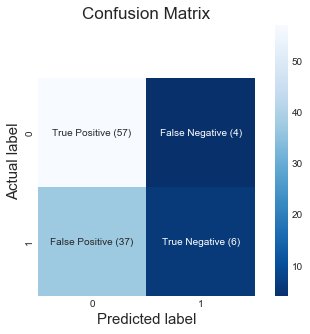

In [400]:
# visualizing LogisiticRegression confusion matrix heatmap
class_report = classification_report(y_test, logreg_pred)
print(class_report)

plt.figure(figsize=(7,5))
annotations = np.array([['True Positive (57)', 'False Negative (4)'], ['False Positive (37)', 'True Negative (6)']])
annotations = annotations.reshape(2,2)
sns.heatmap(cm, cmap = 'Blues_r', square=True, annot=annotations, fmt='')
plt.ylabel('Actual label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.ylim([2, -0.5])
plt.title('Confusion Matrix', fontsize = 17)
plt.show()

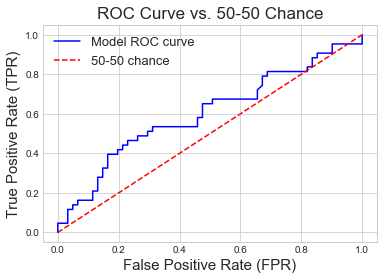

In [401]:
# ROC Curve vs. 50-50 chance line
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Model ROC curve', c='b')
plt.plot([0,1], [0,1], ls = '--', c='r', label='50-50 chance')
plt.title('ROC Curve vs. 50-50 Chance', fontsize=17)
plt.xlabel('False Positive Rate (FPR)', fontsize=15)
plt.ylabel('True Positive Rate (TPR)', fontsize=15)
plt.legend(loc='upper left', fontsize=13)
plt.show()

In [402]:
# GridSearchCV for basic LogisitcRegression 
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l1', 'l2']}

grid_search = GridSearchCV(logreg, param_grid=params, cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

{'C': 0.001, 'penalty': 'l1'}
0.5893719806763285


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

In [403]:
# logistic regression with cross validation, hyperparameters: c=0.001, penalty=l1
final_logreg = LogisticRegression(solver='lbfgs')
cv_scores = cross_val_score(final_logreg, X_test, y_test, cv=10)
print(f'CV Scores Mean: {np.mean(cv_scores)}')
print(f'CV Scores 95% CI: {np.quantile(cv_scores, [0.025, 0.975])}')

CV Scores Mean: 0.6022727272727273
CV Scores 95% CI: [0.4225     0.74488636]


In [404]:
# Decision Tree, visualize using with export_graphviz
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=21)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.5865384615384616

In [405]:
# Bagging Classifier with base model of dt_clf
dt_bag_clf = BaggingClassifier(base_estimator=dt_clf, n_estimators = 10, n_jobs=-1, oob_score = True, random_state=21)
dt_bag_clf.fit(X_train, y_train)
print(dt_bag_clf.score(X_test, y_test))
dt_bag_clf.oob_score_

0.5480769230769231


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.5700483091787439

In [406]:
# Linear SVM
scaler = StandardScaler()
lin_svm_clf = SVC(kernel='linear', C=100)

scaled_svc = Pipeline([('scaler', scaler), ('linear_svc', lin_svm_clf)])
scaled_svc.fit(X_train, y_train)
y_pred = scaled_svc.predict(X_test)
accuracy_score(y_pred, y_test)

0.5865384615384616

In [407]:
# AdaBoostClassifier - final Logistic Regression as base estimator
boost = AdaBoostClassifier(base_estimator=final_logreg)
boost.fit(X_train, y_train)
      
cv_boost_scores = cross_val_score(boost, X_train, y_train, cv=10)
print(f'CV Scores Mean: {np.mean(cv_boost_scores)}')
print(f'CV Scores 95% CI: {np.quantile(cv_boost_scores, [0.025, 0.975])}')

CV Scores Mean: 0.5844947735191638
CV Scores 95% CI: [0.52016551 0.65386179]


### Interest Rates Analysis

In [408]:
interest_rates = pd.read_csv('/Users/jackboydell/Desktop/CS 475/Consumer Sentiment Project/interest_rates_final.csv')
back_up_df2 = interest_rates.copy()
interest_rates.head(15)

,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,fed_funds_rate
0,1978-01-31,1978,1,54,31,9,6,55,1979,9.50
1,1978-02-28,1978,2,48,32,6,14,58,1979,9.50
2,1978-03-31,1978,3,55,34,4,7,49,1979,9.50
3,1978-04-30,1978,4,61,29,4,6,43,1979,9.50
4,1978-05-31,1978,5,57,29,7,7,50,1979,9.50
5,1978-06-30,1978,6,64,28,5,3,41,1979,9.50
6,1978-07-31,1978,7,66,23,6,5,40,1979,9.69
7,1978-08-31,1978,8,59,26,9,6,50,1979,10.24
8,1978-09-30,1978,9,67,23,5,5,38,1979,10.70
9,1978-10-31,1978,10,63,26,6,5,43,1979,11.77


In [409]:
interest_rates.info()
interest_rates['date'] = pd.to_datetime(interest_rates['date']) # changing full date column to Datetime object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
date              512 non-null object
year              512 non-null int64
month             512 non-null int64
go_up             512 non-null int64
stay_same         512 non-null int64
go_down           512 non-null int64
dk_na             512 non-null int64
relative          512 non-null int64
year.1            512 non-null int64
fed_funds_rate    512 non-null float64
dtypes: float64(1), int64(8), object(1)
memory usage: 40.1+ KB


In [410]:
min_i, max_i = interest_rates['fed_funds_rate'].min(), interest_rates['fed_funds_rate'].max()
min_i, max_i

(0.25, 14.0)

In [411]:
# EDA - unemployment rate (SURVEY)
subset2 = interest_rates[interest_rates['date'] >='1999-01-01']
subset2 = subset2[subset2['date'] <= '2000-01-01'].sort_values('fed_funds_rate', ascending=False)
viz2_date = '1999-12-31'
viz2_row = interest_rates.loc[interest_rates['date'] == viz2_date]

subset3 = interest_rates[interest_rates['date'] >='2005-01-01']
subset3 = subset3[subset3['date'] <= '2008-01-01'].sort_values('fed_funds_rate', ascending=False)
viz3_date = '2006-02-28'
viz3_row = interest_rates.loc[interest_rates['date'] == viz3_date]

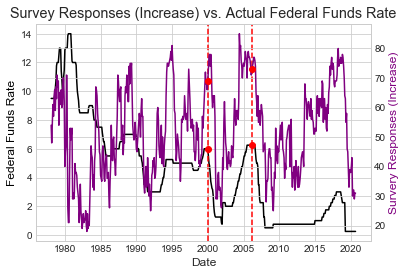

In [412]:
fig, ax1 = plt.subplots()
plt.title('Survey Responses (Increase) vs. Actual Federal Funds Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Funds Rate', c = 'black')
ax1.plot('date', 'fed_funds_rate', data = interest_rates, c='black')

ax1.plot(viz2_row['date'], viz2_row['fed_funds_rate'], marker = 'o', c='red')
ax1.axvline(x=viz2_row['date'], c='red', ls='--')

ax1.plot(viz3_row['date'], viz3_row['fed_funds_rate'], marker = 'o', c='red')
ax1.axvline(x=viz3_row['date'], c='red', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Survery Responses (Increase)', c='purple')
ax2.plot('date', 'go_up', data=interest_rates, c='purple')
ax2.plot(viz2_row['date'], viz2_row['go_up'], marker = 'o', c='red')
ax2.plot(viz3_row['date'], viz3_row['go_up'], marker = 'o', c='red')

plt.show()

The function below takes a given dataframe and specified numerical column and converts into a multiclass (3 class) category. This will be used for classifying the change in interest rates as positive, neutral/no change, or negative.

In [413]:
# calculating negative(-1), neutral(0) or positive(1) one month net change and applying as a categorical variable 
# this can be repeated for other columns that we want to look at as a categoery
def pos_neut_neg_category(df, old_col_name, new_col_name):
    '''
    df: (Pandas DataFrame)
    old_col_name: (name of numerical column to convert to multiclass (3) categories)
    new_col_name: (name to be assigned to new column created)
    '''
    lst = [] 
    for value in df[old_col_name]:
        if value < 0:
            lst.append(-1)
            
        elif value == 0:
            lst.append(0)
            
        else:
            lst.append(1)
            
    df = pd.concat([df, pd.Series(lst, name=new_col_name)], axis=1)
    df[new_col_name] = df[new_col_name].astype('category')
    
    return df

In [414]:
# turning federal funds rate into one month change category
new_col_list = []
previous = 9.5
for value in pd.Series(interest_rates['fed_funds_rate']):
    new_col_list.append(previous - value)
    previous = value
    
one_month_net_change = pd.Series(new_col_list, name='one_month_net_change')
interest_rates = pd.concat([interest_rates, one_month_net_change], axis=1)
print(interest_rates.info())

interest_rates = pos_neut_neg_category(interest_rates, 'one_month_net_change', 'OMNC_cat')
interest_rates.head(25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 11 columns):
date                    512 non-null datetime64[ns]
year                    512 non-null int64
month                   512 non-null int64
go_up                   512 non-null int64
stay_same               512 non-null int64
go_down                 512 non-null int64
dk_na                   512 non-null int64
relative                512 non-null int64
year.1                  512 non-null int64
fed_funds_rate          512 non-null float64
one_month_net_change    512 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(8)
memory usage: 44.1 KB
None


,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,fed_funds_rate,one_month_net_change,OMNC_cat
0,1978-01-31,1978,1,54,31,9,6,55,1979,9.50,0.00,0
1,1978-02-28,1978,2,48,32,6,14,58,1979,9.50,0.00,0
2,1978-03-31,1978,3,55,34,4,7,49,1979,9.50,0.00,0
3,1978-04-30,1978,4,61,29,4,6,43,1979,9.50,0.00,0
4,1978-05-31,1978,5,57,29,7,7,50,1979,9.50,0.00,0
5,1978-06-30,1978,6,64,28,5,3,41,1979,9.50,0.00,0
6,1978-07-31,1978,7,66,23,6,5,40,1979,9.69,-0.19,-1
7,1978-08-31,1978,8,59,26,9,6,50,1979,10.24,-0.55,-1
8,1978-09-30,1978,9,67,23,5,5,38,1979,10.70,-0.46,-1
9,1978-10-31,1978,10,63,26,6,5,43,1979,11.77,-1.07,-1


In [415]:
interest_rates.iloc[12:17]

,date,year,month,go_up,stay_same,go_down,dk_na,relative,year.1,fed_funds_rate,one_month_net_change,OMNC_cat
12,1979-01-31,1979,1,69,20,7,4,38,1980,12.00,0.00,0
13,1979-02-28,1979,2,54,27,13,6,59,1980,12.52,-0.52,-1
14,1979-03-31,1979,3,65,23,7,5,42,1980,13.00,-0.48,-1
15,1979-04-30,1979,4,64,24,8,4,44,1980,13.00,0.00,0
16,1979-05-31,1979,5,61,27,7,5,46,1980,12.94,0.06,1


In [416]:
X = interest_rates.loc[:, ['go_up', 'stay_same', 'go_down', 'dk_na', 'relative']]
print(f'Column Variances:\n{X.var()}') # looking at variances, do we need to impose a standard scale?

y = interest_rates['OMNC_cat'].to_numpy()
X = X.to_numpy() 

Column Variances:
go_up        229.262380
stay_same     77.100779
go_down      119.998223
dk_na          1.955353
relative     619.770758
dtype: float64


Initializing a 80/20 training/testing split and exploring various classification algorithms.

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, stratify=y, random_state = 20)

In [418]:
# linear SVM
scaler = StandardScaler()
lin_svm_clf = SVC(kernel='linear', C=100, class_weight = 'balanced')

scaled_svc = Pipeline([('scaler', scaler), ('linear_svc', lin_svm_clf)])
scaled_svc.fit(X_train, y_train)
training_SVM_pred = scaled_svc.predict(X_train)
SVM_y_pred = scaled_svc.predict(X_test)
training_score = scaled_svc.score(X_train, y_train)
print(f'Training Score: {training_score}')
SVM_score = lin_svm_clf.score(X_test, y_test)
SVM_score

Training Score: 0.4889975550122249


0.5533980582524272

In [419]:
# LogisiticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
logreg.fit(X_train, y_train)
log_y_pred = logreg.predict(X_test)
log_acc_score = logreg.score(X_test, y_test)
print(f'Accuracy score: {log_acc_score}')
y_pred_proba = logreg.predict_proba(X_test)[:,1]

Accuracy score: 0.4854368932038835


In [420]:
# Decision Trees Classifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=21, class_weight='balanced')
dt_clf.fit(X_train, y_train)
print(dt_clf.score(X_test, y_test))
dt_y_pred = dt_clf.predict(X_test)

0.36893203883495146


Exploring potential ensemble methods for classification purposes.

In [421]:
# Voting Classifier with below models... is this good in multiclass setting? probably not as effective 
estimators=[('LogisitcRegression', logreg), ('Scaled_SVM', scaled_svc), ('DecisionTree', dt_clf)]
lin_vc = VotingClassifier(estimators=estimators)
lin_vc.fit(X_train, y_train)
lin_vc.score(X_test,y_test)

0.47572815533980584

In [422]:
#BaggingClassifier for linear SVM
bag = BaggingClassifier(scaled_svc, n_estimators=5, n_jobs=-1)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.47572815533980584

Visualizing model classification performance.

[[ 5  5  3]
 [26 41  9]
 [ 9  2  3]]
              precision    recall  f1-score   support

          -1       0.12      0.38      0.19        13
           0       0.85      0.54      0.66        76
           1       0.20      0.21      0.21        14

    accuracy                           0.48       103
   macro avg       0.39      0.38      0.35       103
weighted avg       0.67      0.48      0.54       103



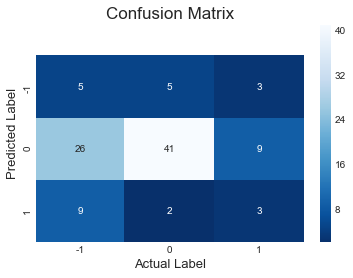

In [423]:
# visualizing Linear SVM confusion matrix heatmap
cm_2 = confusion_matrix(y_test, SVM_y_pred)
class_report2 = classification_report(y_test, SVM_y_pred)
print(cm_2)
print(class_report2)
cm_2_df = pd.DataFrame(cm_2, index = [-1,0,1], columns =[-1,0,1])

sns.heatmap(cm_2_df, annot=True, cmap='Blues_r')
plt.ylim([3,-0.5])
plt.xlabel('Actual Label', fontsize=13)
plt.ylabel('Predicted Label', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

### Anamoly/Outlier Detection (Interest Rates) - OneClassSVM

In [424]:
# anamoly detection using OneClassSVM - interest rates 
cols = ['go_up', 'stay_same', 'go_down', 'dk_na', 'relative']
an_detec = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.03, random_state=21) # percentage to consider outliers
an_detec.fit(interest_rates[cols])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
            max_iter=-1, nu=0.03, random_state=21, shrinking=True, tol=0.001,
            verbose=False)

In [425]:
y_pred = an_detec.predict(interest_rates[cols])
print(interest_rates['fed_funds_rate'].mean())

# filter outlier index
outlier_index = np.where(y_pred == -1) 
# filter outlier values
outlier_rows = interest_rates.iloc[outlier_index]
print(len(outlier_rows))
outlier_rows.head()

oneclass_outliers = outlier_rows.values

4.459687499999999
16


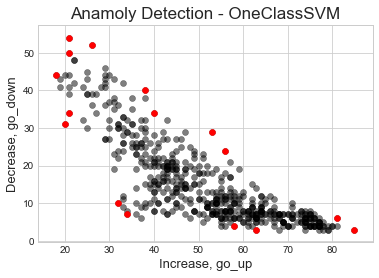

In [426]:
# visulalizing outliers: 1) 2D plot of survery counts, 2) distribution of outliers subset 
#plt.set_style.context(style = 'seaborn-darkgrid') # figure this out
#sns.set_theme('darkgrid')
plt.scatter(x = 'go_up', y ='go_down', data = interest_rates, c='black', alpha=0.5)
plt.scatter(x = 'go_up', y = 'go_down', data = outlier_rows, c='red')
plt.title('Anamoly Detection - OneClassSVM', fontsize=17)
plt.xlabel('Increase, go_up', fontsize=13)
plt.ylabel('Decrease, go_down', fontsize=13)

plt.show()

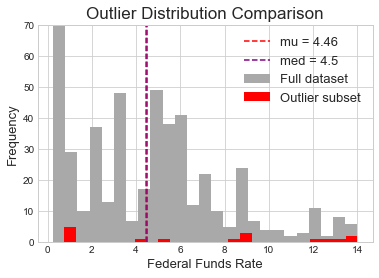

In [427]:
# 2) distribution of outliers
mu = interest_rates['fed_funds_rate'].mean()
med = interest_rates['fed_funds_rate'].quantile(0.5)

plt.hist('fed_funds_rate', data=interest_rates, bins=25, label='Full dataset', color='darkgray')
plt.hist('fed_funds_rate', data=outlier_rows, bins=25, label='Outlier subset', color='r')
plt.axvline(x=mu, ls='--', c='r', label=f'mu = {np.round(mu,2)}')
plt.axvline(x=med, ls='--', c='purple', label = f'med = {np.round(med,2)}')

plt.ylim(0,70)

plt.legend(fontsize=13, loc='best')
plt.title('Outlier Distribution Comparison', fontsize=17)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Federal Funds Rate', fontsize=13)
plt.show()


### Anamoly/Outlier Detection (Interest Rates) - KMeans Clustering

In [428]:
# anomaly detection using clustering model (KMeans)
kmeans = KMeans(n_clusters = 5)
kmeans.fit(interest_rates[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Cluster selection using inertia and silouhette score as decision metrics.

Text(4.5, 70000, 'Elbow')

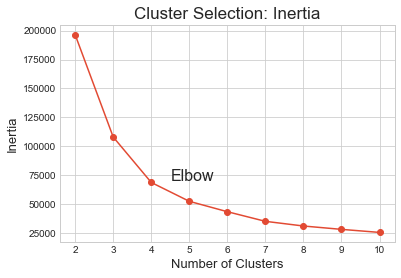

In [429]:
# finding the number of clusters to use in our KMeans clustering model 
numb_clusters = np.arange(2,11).astype(int)
inertias = []
sil_scores = []
for k in numb_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(interest_rates[cols])
    
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(interest_rates[cols], kmeans.labels_))

plt.plot(numb_clusters, inertias, marker = 'o')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Inertia', fontsize=13)
plt.title('Cluster Selection: Inertia', fontsize=17) 
plt.text(x = 4.5, y = 70000, s='Elbow', fontsize=16)

Text(0.5, 1.0, 'Cluster Selection: Silouhette Score')

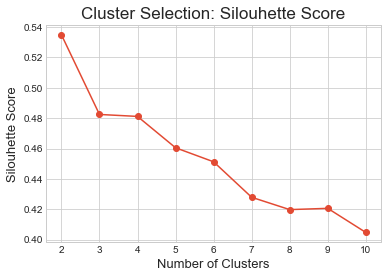

In [430]:
plt.plot(numb_clusters, sil_scores, marker = 'o')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silouhette Score', fontsize=13)
plt.title('Cluster Selection: Silouhette Score', fontsize=17) # without above graph, looks like k=4

Fitting a KMeans clustering algorithm with k=4 to identlfy potential outliers (instances with a euclidean distance to it's clusters centroid being in the 97th percentile, larger than 97 percent of the total instances).

In [431]:
X = interest_rates[cols].values
an_model = KMeans(n_clusters = 4)
clusters = an_model.fit_predict(X)

In [432]:
centroids = an_model.cluster_centers_
points = np.empty((0,len(X[0])), float)
distances = np.empty((0,len(X[0])), float)

for i,v in enumerate(centroids):
    distances = np.append(distances, cdist([v], X[clusters == i], 'euclidean')) 
    points = np.append(points, X[clusters == i], axis=0)

percentile = 97
outliers = X[np.where(distances > np.percentile(distances, [percentile]))]

In [435]:
print(f'Kmeans: \n{outliers}\n')
print(f'OneClassSVM: \n{oneclass_outliers}')

Kmeans: 
[[ 30  38  30   2 100]
 [ 34  31  32   3  98]
 [ 40  37  21   2  81]
 [ 47  35  15   3  68]
 [ 54  34  11   1  57]
 [ 41  42  15   2  74]
 [ 40  42  16   2  76]
 [ 77  16   5   2  28]
 [ 64  23  12   1  48]
 [ 54  34  11   1  57]
 [ 77  17   4   2  28]
 [ 75  20   4   1  29]
 [ 77  18   4   1  27]
 [ 74  21   3   2  29]
 [ 63  29   7   1  44]
 [ 31  44  23   2  92]]

OneClassSVM: 
[[Timestamp('1979-12-31 00:00:00') 1979 12 40 22 34 4 94 1980 12.87
  -1.3999999999999986 -1]
 [Timestamp('1980-04-30 00:00:00') 1980 4 56 18 24 2 68 1981 13.0 0.0 0]
 [Timestamp('1980-05-31 00:00:00') 1980 5 26 20 52 2 126 1981 13.87
  -0.8699999999999992 -1]
 [Timestamp('1980-06-30 00:00:00') 1980 6 21 22 54 3 133 1981 14.0
  -0.13000000000000078 -1]
 [Timestamp('1980-12-31 00:00:00') 1980 12 53 14 29 4 76 1981 12.1
  0.9299999999999997 1]
 [Timestamp('1981-12-31 00:00:00') 1981 12 21 25 50 4 129 1982 8.73
  0.6199999999999992 1]
 [Timestamp('1983-01-31 00:00:00') 1983 1 18 35 44 3 126 1984 8.5 0.0

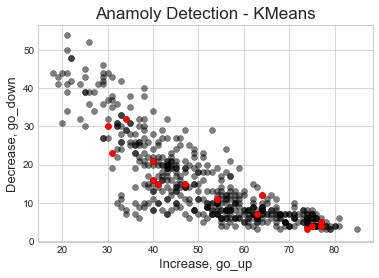

In [434]:
# visulalizing outliers: 1) 2D plot of survery counts, 2) distribution of outliers subset 
#plt.set_style.context(style = 'seaborn-darkgrid') # figure this out
plt.scatter(x = 'go_up', y ='go_down', data = interest_rates, c='black', alpha=0.5)
plt.scatter(outliers[:,0], y = outliers[:,2], c='red')
plt.title('Anamoly Detection - KMeans', fontsize=17)
plt.xlabel('Increase, go_up', fontsize=13)
plt.ylabel('Decrease, go_down', fontsize=13)

plt.show()